<a href="https://colab.research.google.com/github/mandem296/Depression_detection_BERT_model/blob/main/ROBERTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

import numpy as np

import re

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf

In [5]:
from google.colab import files
uploaded = files.upload()
df=pd.read_csv('/content/Mental-Health-Twitter.csv')

Saving Mental-Health-Twitter.csv to Mental-Health-Twitter.csv


1    10000
0    10000
Name: label, dtype: int64


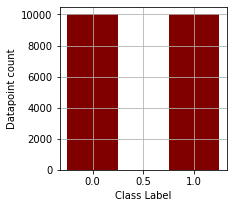

In [6]:
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(3,3))
plt.bar(label_counts.index, label_counts,color ='maroon',
        width = 0.5)
plt.xlabel("Class Label")
plt.ylabel("Datapoint count")
plt.grid()
plt.show()

In [7]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 11.4 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=ea2cfc79048eb7c0724b5606fbf982caf64f175899b50fb4d029f9ee8981fd9b
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [8]:
import re
import emoji
#defining the function to remove punctuation
def remove_unnecessary(post_text):
    post_text = re.sub('http[s]?://\S+', '', post_text)
    #strip numbers
    post_text = re.sub('[0-9]+', '', post_text)
    #remove emojis
    post_text = emoji.demojize(post_text)
    return post_text

#storing the unnecessary free text
df['post_text']= df['post_text'].apply(lambda x:remove_unnecessary(x))

In [9]:
import string
string.punctuation
#defining the function to remove punctuation
def remove_punctuation(post_text):
    punctuationfree="".join([i for i in post_text if i not in string.punctuation])
    return punctuationfree

#storing the puntuation free text
df['post_text']= df['post_text'].apply(lambda x:remove_punctuation(x))

In [10]:
df['post_text']= df['post_text'].apply(lambda x: x.lower())

In [11]:
df_dup = df[df['post_text'].duplicated()]
text_arr = np.unique(df_dup['post_text'].values)
df_dup = df[df['post_text'].isin(text_arr)].sort_values(by=['post_text'])
df_dup = df_dup[~df_dup.duplicated()].sort_values(by=['post_text'])
df_dup_contradiction = df_dup[df_dup['post_text'].duplicated()]
df_dup_contradiction.to_csv("ambiguous_datapoints_bert.csv")
df_dedup = df.drop_duplicates(subset=['post_text'])
df_dedup = df_dedup[~df_dedup['post_text'].isin(df_dup_contradiction['post_text'].values)]

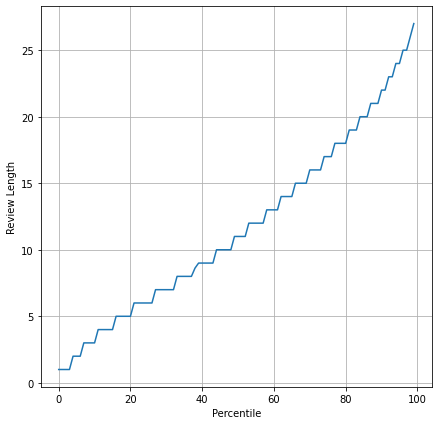

In [12]:
review_len = np.array([len(x.split()) for x in df['post_text'].values])
review_len = np.sort(review_len)
review_len_percnt = np.percentile(review_len,range(100))
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(range(100),review_len_percnt)
ax.set_xlabel("Percentile")
ax.set_ylabel("Review Length")
plt.grid()
plt.show()

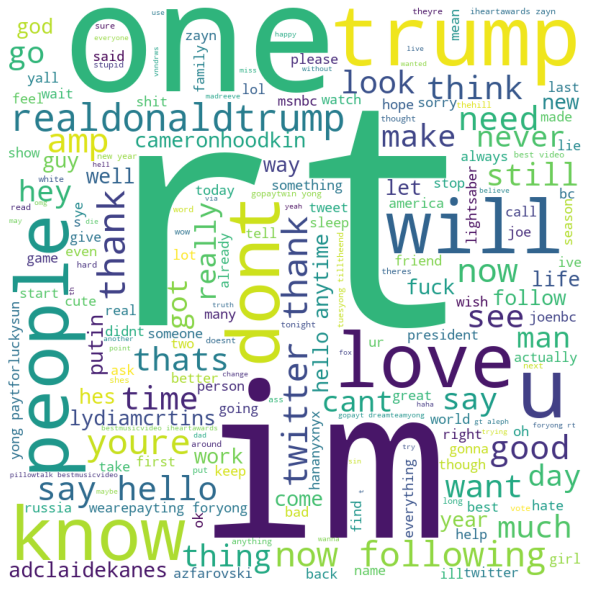

In [13]:
positive_sentences = ""
for sentence in df[df['label'] == 0]['post_text'].tolist():
    positive_sentences = positive_sentences + " "+sentence
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_sentences)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

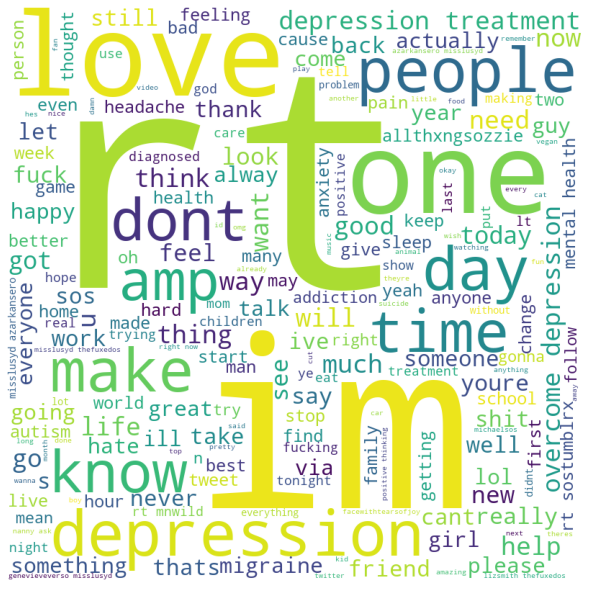

In [14]:
negative_sentences = ""
for sentence in df_dedup[df_dedup['label'] == 1]['post_text'].tolist():
    negative_sentences = negative_sentences + " "+sentence
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_sentences)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [15]:
df = df.loc[:,['post_text','label']]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_text  20000 non-null  object
 1   label      20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 13.3 MB/s 
     |████████████████████████████████| 7.6 MB 55.7 MB/s 
     |████████████████████████████████| 182 kB 64.4 MB/s 


In [18]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_dedup['post_text'],df_dedup['label'], stratify=df_dedup['label'],random_state=35,test_size=0.1)

In [19]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
train_inputs = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text
train_labels = y_train
test_inputs = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text
test_labels = y_test

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
class LossOnHistoryRobert(tf.keras.callbacks.Callback):

    def __init__(self,x_val,y_val):

        self.x_val = x_val

        self.y_val = y_val

    def on_train_begin(self, logs={}):

        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [],'val_f1': []}

    def on_epoch_end(self, epoch, logs={}):  

        true_positives=0

        self.history['loss'].append(logs.get('loss'))

        self.history['accuracy'].append(logs.get('accuracy'))

        if logs.get('val_loss', -1) != -1:

            self.history['val_loss'].append(logs.get('val_loss'))

        if logs.get('val_accuracy', -1) != -1:

            self.history['val_accuracy'].append(logs.get('val_accuracy'))

        #y_pred gives us the probability value 

        y_pred= self.model.predict(self.x_val)

        y_pred = np.argmax(np.array(y_pred.logits),axis=1)

        #The micro_f1 score

        f1 = f1_score(self.y_val.values, y_pred)

	#confusion_matrix

        print(confusion_matrix(self.y_val.values, y_pred))

        self.history['val_f1'].append(f1)

        print('F1_Score: ',f1)

model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

model.compile(

        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.),

        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

        metrics=[tf.metrics.SparseCategoricalAccuracy()],

        )

In [ ]:
history_own=LossOnHistoryRobert(dict(test_inputs),test_labels) 
history=model.fit(dict(train_inputs),train_labels, validation_data=[dict(test_inputs),test_labels], batch_size=32,epochs=1, verbose=1, callbacks=history_own)